In [1]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [3]:
date = "24_01_2024"
genotype = "R40D05_sytjGCaMP7f_CsChrimsontdT"
fly = "fly1"
session = 'l_bulb-004'
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage1/2PData/{genotype}/{date}/{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

h5name = f'/media/mplitt/SSD_storage1/2P_scratch/{genotype}/{date}/{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'], first_chan=1)
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)

(288, 473)
[########################################] | 100% Completed | 24.95 s


In [4]:
f = h5py.File(h5name)
data = f['/data'][:]

In [5]:
ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[0,:,:,:], in_place=False)

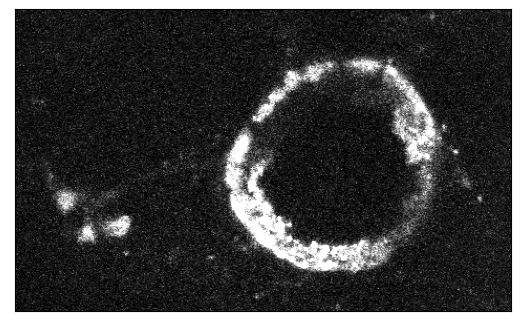

In [6]:
fig, ax = plt.subplots()
# ax.imshow(ref_img[0,:,:,:].max(axis=0), cmap='Greys_r')
im = data_corr[1,:,:,:,:].mean(axis=0).max(axis=0)
ax.imshow(im, cmap='Greys_r', vmax = np.percentile(im,98),vmin=np.percentile(im,0))
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(f'/media/mplitt/SSD_storage1/2P_scratch/{genotype}/{date}/{fly}/{session}/ref_img.pdf', format='pdf')

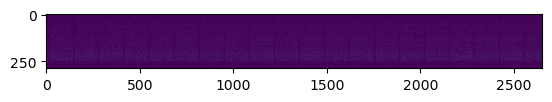

In [7]:
fig,ax = plt.subplots()
ax.imshow(data_corr[1,:,2,:,:].mean(axis=-1).T)

In [8]:
ref_img_file = f'/media/mplitt/SSD_storage1/2P_scratch/{genotype}/{date}/{fly}/{session}/ref_img.npy'
np.save(ref_img_file, im)

In [9]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession().new_session(data_corr.mean(axis=1))

In [10]:
napari_outputs_file = f'/media/mplitt/SSD_storage1/2P_scratch/{genotype}/{date}/{fly}/{session}/napari.pkl'

In [9]:
eb_napari_ = st2p.preprocessing.napari_tools.EllipsoidBodySession()
eb_napari_.open_existing_session(napari_outputs_file)

masks = eb_napari_.masks
bckgnd = eb_napari_.background.data

FileNotFoundError: [Errno 2] No such file or directory: '/media/mplitt/SSD_storage1/2P_scratch/R40D05_sytjGCaMP7f_CsChrimsontdT/11_12_2023/fly2/r_glom4_stim-006/napari.pkl'

In [11]:
eb_napari.make_phase_masks(n_rois=16)
# 
masks = eb_napari.masks
bckgnd = eb_napari.background.data

In [12]:
eb_napari.save_layers(napari_outputs_file)

In [13]:
from glob import glob
csv_files = glob(f'/media/mplitt/SSD_storage1/2PData/{genotype}/{date}/{fly}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()

In [14]:
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [15]:
F, notF = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks, 16, bckgnd_mask = bckgnd, max_proj=False) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [16]:
F.shape
# F[np.isnan(F)] = 0



(2, 16, 2653)

In [17]:
import sklearn
from sklearn.linear_model import LinearRegression as LinReg


# F  = F - 0*notF[:, np.newaxis,:]
nanmask = np.isnan(F)
F[nanmask]=0
coef = 1.0
for ch in range(F.shape[0]):
    lr = LinReg().fit(notF[ch,np.newaxis, :].T, F[ch,:,:].T)
    F[ch,:,:] = F[ch,:,:]-coef*lr.predict(notF[ch,np.newaxis,:].T).T  #+ lr.intercept_[:,np.newaxis]
    
F[nanmask]=np.nan
data_corr.shape


F_sm = sp.ndimage.gaussian_filter1d(F,2,axis=-1)
F_sm = sp.ndimage.gaussian_filter1d(F_sm,.5,axis=1, mode='wrap')
# F[:,:,df_aligned[' Opto Trigger']>.5]=np.nan


F_base = sp.ndimage.median_filter(F, size=(1,1,200), mode='constant')
# F_base = sp.ndimage.gaussian_filter1d(F[:,:,400:],30, axis=-1)
F_base = np.percentile(F_base,10,axis=-1, keepdims=True)


whole_frame_ts = data_corr.mean(axis=-1).mean(axis=-1).mean(axis=-1)


In [18]:

# dff = sp.stats.zscore(F_sm[1,:,:],axis=-1)
dff = sp.stats.zscore(F[1,:,:],axis=-1)
# dff = sp.stats.zscore(F[1,:,:]/np.linalg.norm(F[1,:,:], axis=0, keepdims=True), axis=-1)


In [19]:
df_aligned.columns
# dff[:2,:] = np.nan
# dff[-2:,:]= np.nan

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')

In [20]:
x_f,y_f = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])

_, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           np.pi-1*df_aligned[' Heading'].to_numpy().ravel()))


# rho,phi = st2p.utilities.cart2pol(np.nanmean(x_f, axis=0), np.nanmean(y_f, axis=0))
rho,phi = st2p.utilities.cart2pol(np.nanmean(x_f, axis=0), np.nanmean(y_f, axis=0))
_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))



(array([204., 265., 221., 193., 244., 241., 225., 231., 214., 215.]),
 array([-3.13819514e+00, -2.51082359e+00, -1.88345203e+00, -1.25608048e+00,
        -6.28708930e-01, -1.33737795e-03,  6.26034174e-01,  1.25340573e+00,
         1.88077728e+00,  2.50814883e+00,  3.13552038e+00]),
 <BarContainer object of 10 artists>)

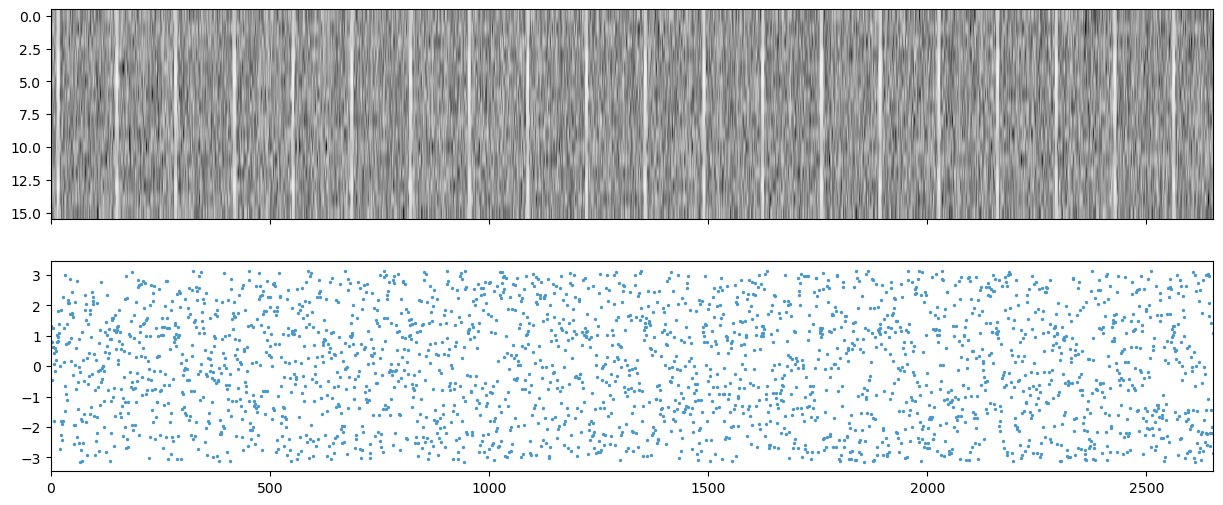

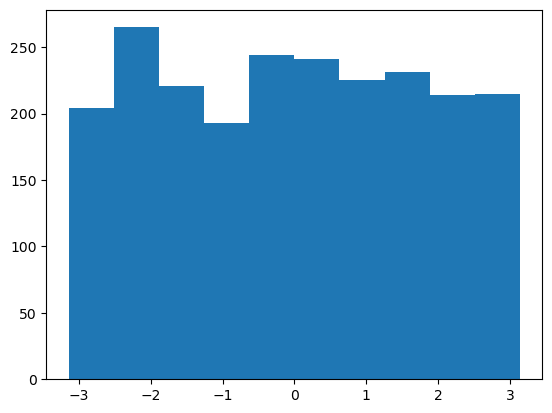

In [21]:
%matplotlib inline
fig, ax = plt.subplots(2,1, sharex=True, figsize = [15,6])
ax[0].imshow(dff, aspect='auto', cmap = 'Greys', vmin=-3, vmax=3)
x = np.arange(dff.shape[1])
# ax[0].scatter(x,15*(heading+np.pi)/2/np.pi,color='red',marker='.',s=2)
# ax[0].scatter(x,15*(phi+np.pi)/2/np.pi,color='cyan', s=2)

# ax[1].plot(df_aligned[' Heading']+5)
ax[1].scatter(x,phi,s=2, color=plt.cm.Blues(.6))

fig, ax = plt.subplots()
ax.hist(offset[400:])


In [26]:
%matplotlib qt
fig, ax  = plt.subplots(figsize=[15,3])
ax.plot(x, np.nanmean(dff[:,:],axis=0))

fig.show()
# ax.set_ylim([-1,3])

In [27]:
thresh = -.7
opto = st2p.preprocessing.signals.rising_edges(np.nanmean(dff[:,:],axis=0)>-1)


opto[0]=0
redges = np.argwhere(opto==1).ravel()

response = np.zeros([redges.shape[0],65])
for r, redge in enumerate(redges):
    response[r,:] =  np.nanmean(dff[:,redge+1:redge+66],axis=0)

    
# response_z = sp.stats.zscore(response, axis=1)
fig,ax = plt.subplots()

xx = np.arange(response.shape[1])
ax.plot(xx,np.nanmean(response, axis=0))
# ax.plot(xx,response_z.T)
mu, sem = response.mean(axis=0), sp.stats.sem(response,axis=0)
ax.fill_between(xx, mu-sem, mu+sem, alpha=.3)
ax.set_ylabel('Norm F')
ax.set_xlabel('Frames')

Text(0.5, 0, 'Frames')

In [28]:
%matplotlib qt
fig, ax = plt.subplots()
ax.plot(notF[1,:])

In [29]:
max_inds = (15*(heading+np.pi)/2/np.pi).astype(int)
dff_maxal = 0*dff
for t in range(dff.shape[1]):
    dff_maxal[:,t] = np.roll(dff[:,t], -max_inds[t])
    

dff_maxal = dff_maxal/np.linalg.norm(dff_maxal, axis=0, keepdims=True)


start, end = 0, -1

fig, ax = plt.subplots(2, 1, figsize=[20,6], sharex=True)
ax[0].imshow(dff[:,start:end],aspect='auto',cmap='Blues', interpolation=None)
ax[1].imshow(dff_maxal[:,start:end],aspect='auto',cmap='Blues', interpolation=None) #,vmin=-3,vmax=3)



fig, ax = plt.subplots()
mu, sem = dff_maxal[:,start:end].mean(axis=-1), sp.stats.sem(dff_maxal[:, start:end], axis=-1)

ax.plot(mu, color='blue')
ax.fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='blue')

ax.set_title('Temporal average of heading-centered Data')
ax.set_xlabel('wedge (centered)')
ax.set_ylabel('Normalized activity')


Text(0, 0.5, 'Normalized activity')

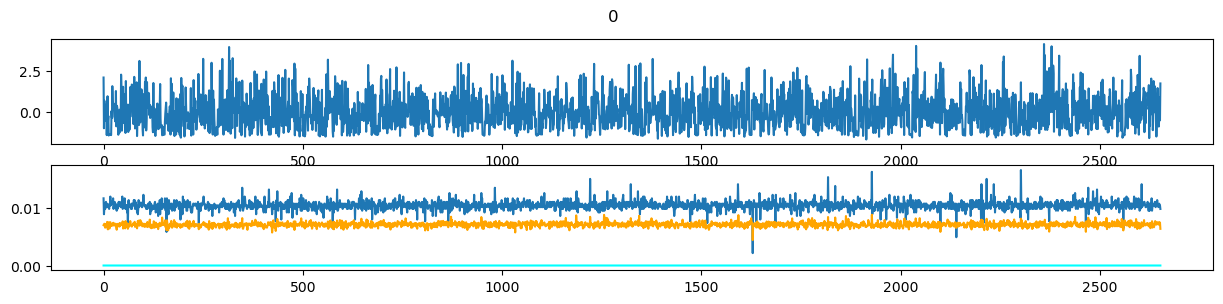

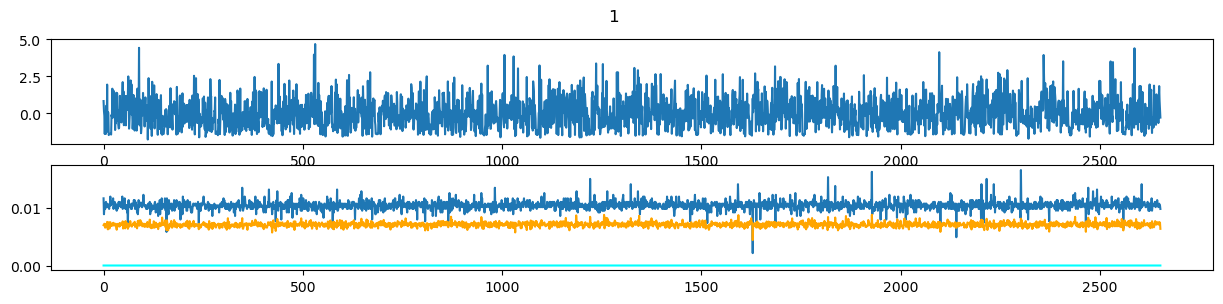

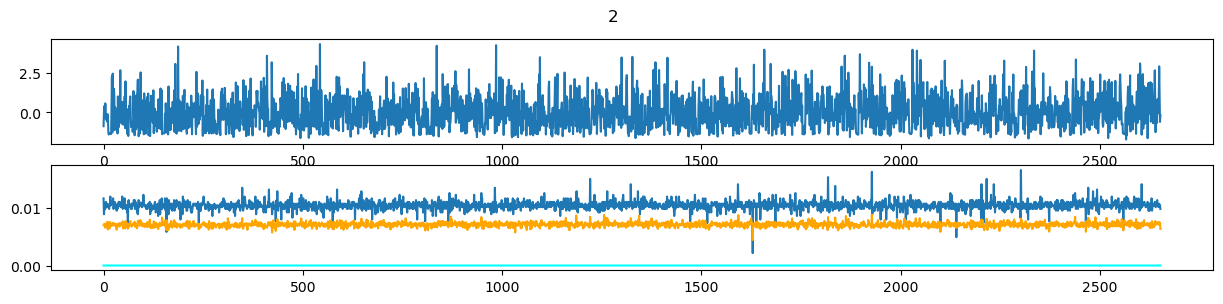

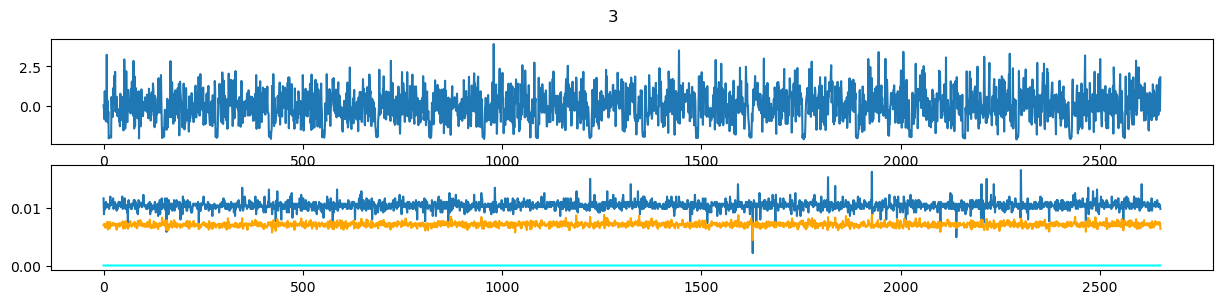

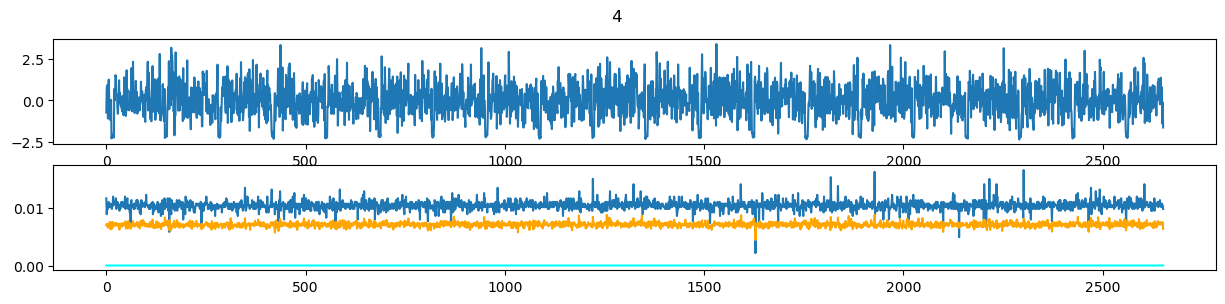

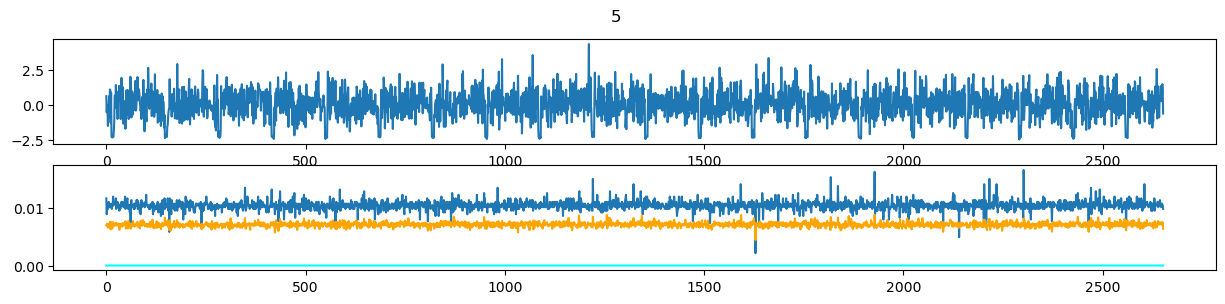

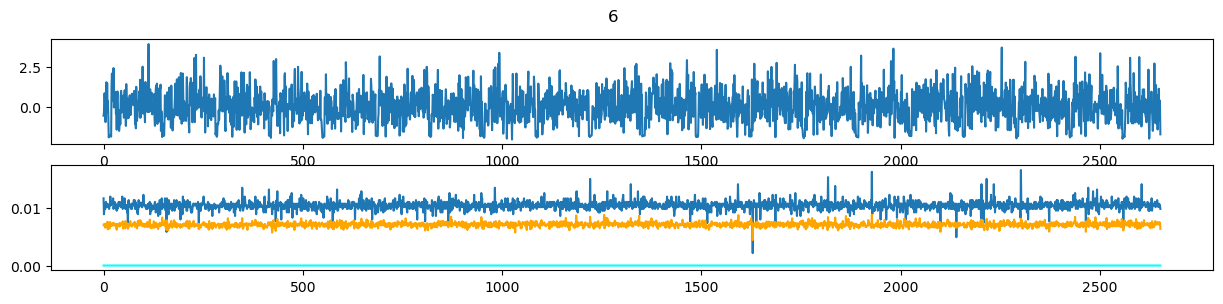

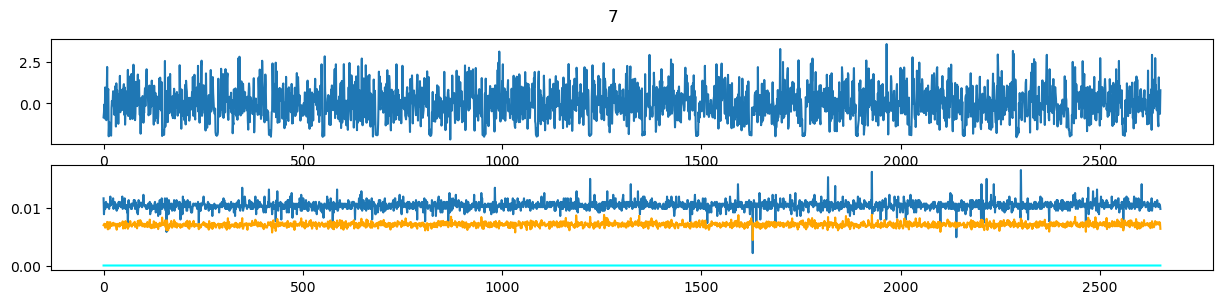

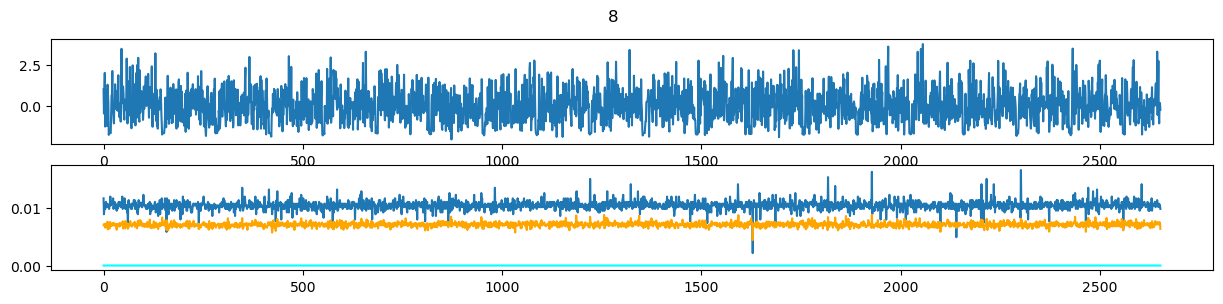

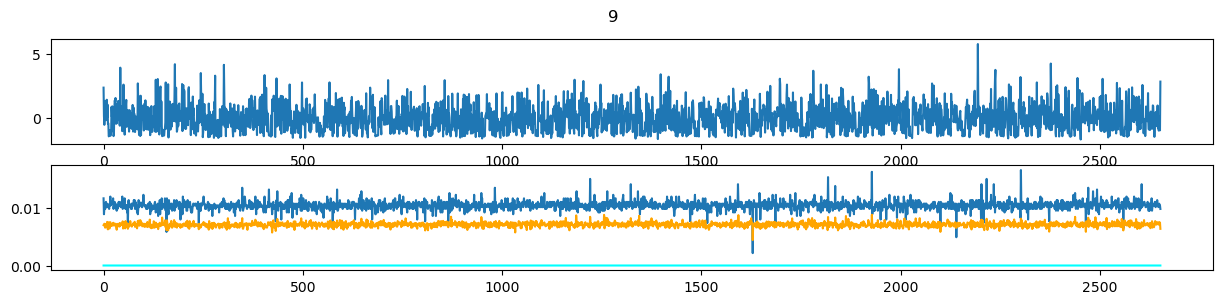

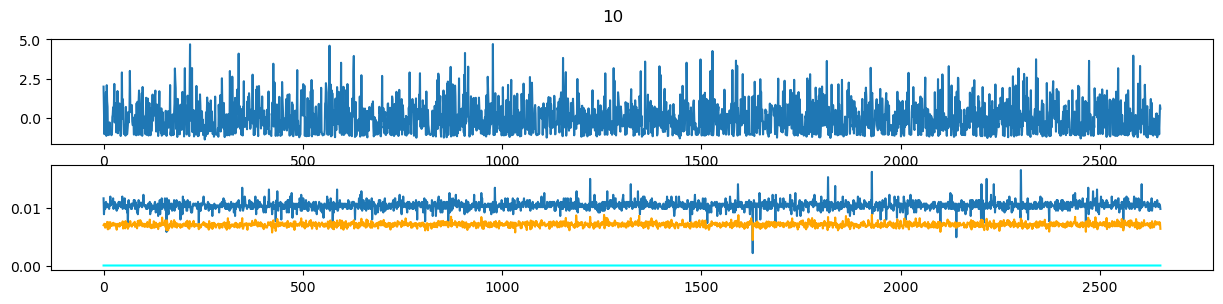

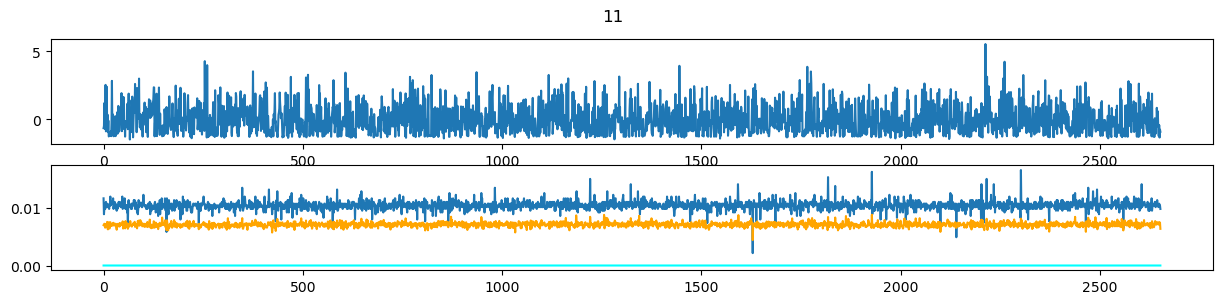

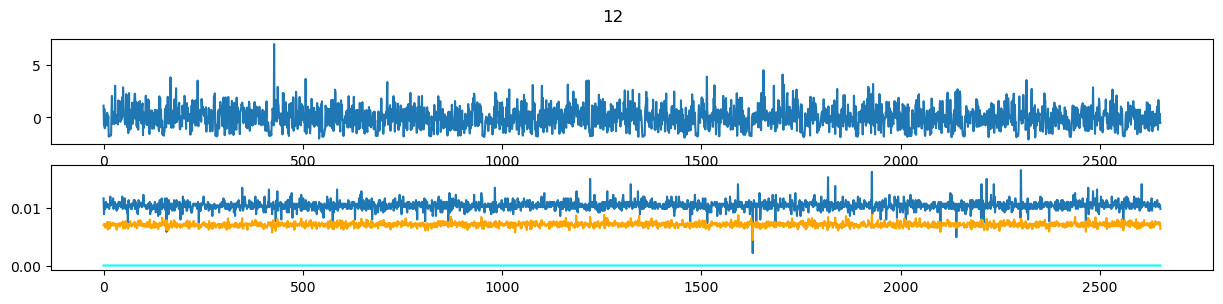

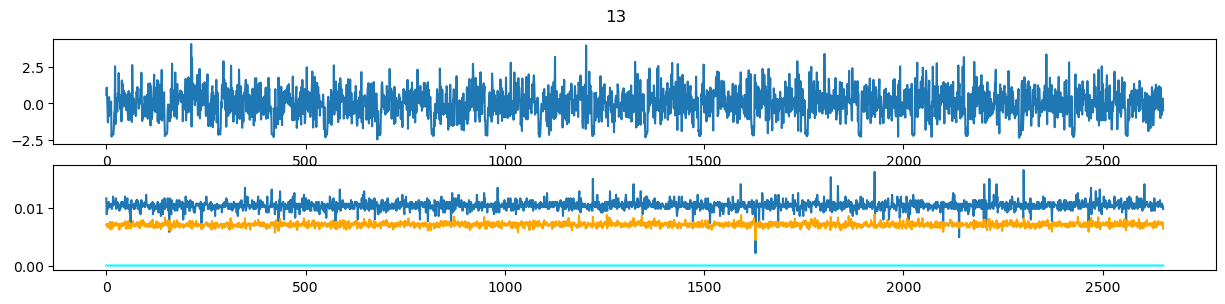

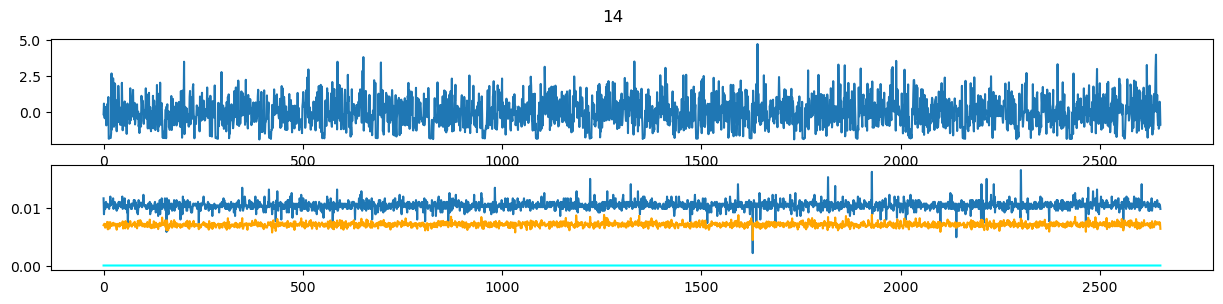

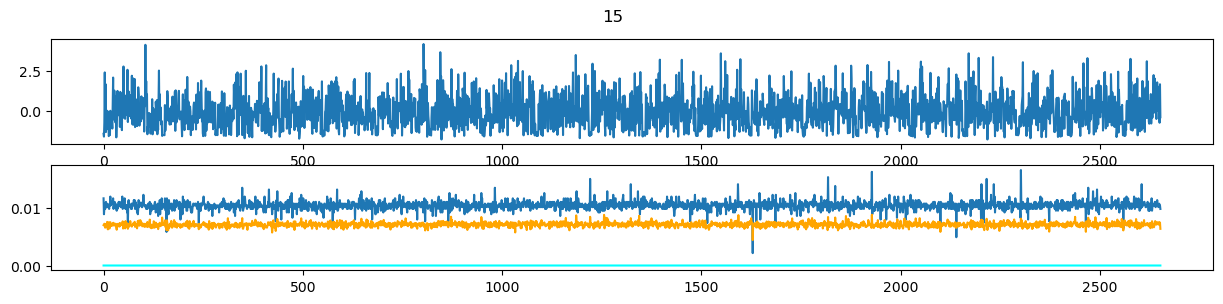

In [30]:
%matplotlib inline
for r in range(16):
    fig, ax = plt.subplots(2,1, figsize = [15,3])
    ax[0].plot(dff[r, :])
    # ax[0].set_ylim([-1,2])
    ax[1].plot(df_aligned[' Heading'], color='orange')
    ax[1].plot(df_aligned[' Opto Trigger'], color='cyan')
    ax[1].plot(df_aligned[' Y/Index'], zorder=-1)
    fig.suptitle(f'{r}')

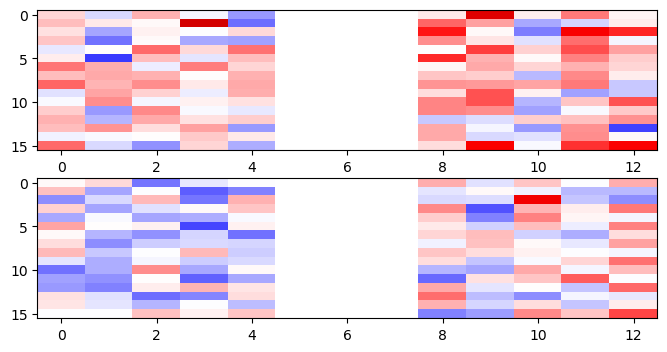

In [51]:
bar_loc0 = (df_aligned[' Heading'].to_numpy()>1.5) * (df_aligned[' Y/Index'].to_numpy()<5)
# bar_loc0[df_aligned[' Y/Index']>
bar_loc0_starts = np.argwhere(bar_loc0[1:]>bar_loc0[:-1]).ravel() - 1
bar_loc0_stops = np.argwhere(bar_loc0[1:]<bar_loc0[:-1]).ravel() + 1

bar_loc1 = (df_aligned[' Heading'].to_numpy()<-1.5) * (df_aligned[' Y/Index'].to_numpy()<5)
bar_loc1_starts = np.argwhere(bar_loc1[1:]>bar_loc1[:-1]).ravel() - 1
bar_loc1_stops = np.argwhere(bar_loc1[1:]<bar_loc1[:-1]).ravel() + 1


dff_loc0 = np.zeros((dff.shape[0], bar_loc0_starts.shape[0]))
for i, (start, stop) in enumerate(zip(bar_loc0_starts, bar_loc0_stops)):
    dff_loc0[:,i] = dff[:,start:stop].mean(axis=-1) - dff[:,start-5:start].mean(axis=-1)
    
dff_loc1 = np.zeros((dff.shape[0], bar_loc1_starts.shape[0]))
for i, (start, stop) in enumerate(zip(bar_loc1_starts, bar_loc1_stops)):
    dff_loc1[:,i] = dff[:,start:stop].mean(axis=-1) - dff[:,start-5:start].mean(axis=-1)

fig, ax = plt.subplots(2,1, figsize=[8,4])

diff0 = dff_loc0 #- dff_loc0[:,:5].mean(axis=-1, keepdims=True)
diff0[:,5:8]=np.nan
ax[0].imshow(diff0[:,:], cmap='seismic', aspect='auto', vmin=-5, vmax=5)

diff1 = dff_loc1 #- dff_loc1[:,:5].mean(axis=-1, keepdims=True)
diff1[:,5:8]=np.nan
ax[1].imshow(diff1[:,:], cmap='seismic', aspect='auto', vmin=-5, vmax=5)



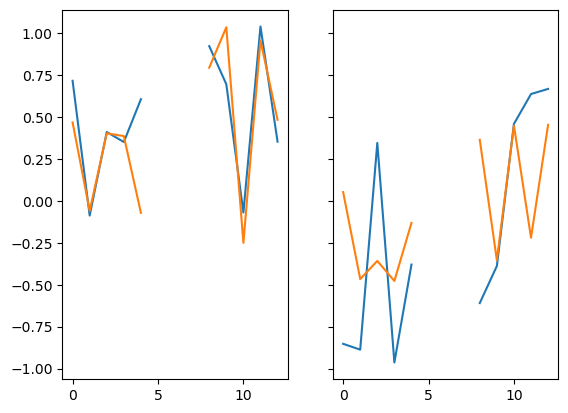

In [52]:
fig, ax= plt.subplots(1,2, sharey = True)
mask0 = np.zeros([16,])
mask0[5:8]=1
mask0=mask0>0

mask1 = np.zeros([16,])
mask1[9:12]=1
mask1=mask1>0
ax[0].plot(diff0[mask0,:].mean(axis=0))
ax[0].plot(diff0[~mask0,:].mean(axis=0))

# fig, ax= plt.subplots()

ax[1].plot(diff1[mask1,:].mean(axis=0))
ax[1].plot(diff1[~mask1,:].mean(axis=0))